# Import Dependencies

In [2]:
import os
import pandas as pd
import numpy as np
import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import xml.etree.ElementTree as ET

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import Input, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dog-and-cat-detection/annotations/Cats_Test2888.xml
/kaggle/input/dog-and-cat-detection/annotations/Cats_Test1617.xml
/kaggle/input/dog-and-cat-detection/annotations/Cats_Test83.xml
/kaggle/input/dog-and-cat-detection/annotations/Cats_Test899.xml
/kaggle/input/dog-and-cat-detection/annotations/Cats_Test1204.xml
/kaggle/input/dog-and-cat-detection/annotations/Cats_Test603.xml
/kaggle/input/dog-and-cat-detection/annotations/Cats_Test2365.xml
/kaggle/input/dog-and-cat-detection/annotations/Cats_Test380.xml
/kaggle/input/dog-and-cat-detection/annotations/Cats_Test1300.xml
/kaggle/input/dog-and-cat-detection/annotations/Cats_Test3380.xml
/kaggle/input/dog-and-cat-detection/annotations/Cats_Test3246.xml
/kaggle/input/dog-and-cat-detection/annotations/Cats_Test1979.xml
/kaggle/input/dog-and-cat-detection/annotations/Cats_Test147.xml
/kaggle/input/dog-and-cat-detection/annotations/Cats_Test3153.xml
/kaggle/input/dog-and-cat-detection/annotations/Cats_Test985.xml
/kaggle/input/dog

# Load and Preprocess Data

In [89]:
images_path = Path('/kaggle/input/dog-and-cat-detection/images')
anno_path = Path('/kaggle/input/dog-and-cat-detection/annotations')

In [90]:
def filelist(root, file_type):
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]


def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [91]:
df_train = generate_train_df(anno_path)
class_dict = {'cat': 0, 'dog': 1}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])
df_train

filename width height  class  \
0     /kaggle/input/dog-and-cat-detection/images/Cat...   313    310      0   
1     /kaggle/input/dog-and-cat-detection/images/Cat...   500    417      1   
2     /kaggle/input/dog-and-cat-detection/images/Cat...   500    375      1   
3     /kaggle/input/dog-and-cat-detection/images/Cat...   500    375      1   
4     /kaggle/input/dog-and-cat-detection/images/Cat...   500    334      1   
...                                                 ...   ...    ...    ...   
3681  /kaggle/input/dog-and-cat-detection/images/Cat...   200    179      0   
3682  /kaggle/input/dog-and-cat-detection/images/Cat...   300    238      0   
3683  /kaggle/input/dog-and-cat-detection/images/Cat...   500    333      1   
3684  /kaggle/input/dog-and-cat-detection/images/Cat...   500    359      0   
3685  /kaggle/input/dog-and-cat-detection/images/Cat...   400    372      0   

      xmin  ymin  xmax  ymax  
0       99    34   238   183  
1      183    92   291   259  
2      155   119   356   250  
3      193    85   305   179  
4      284    58   363   128  
...    ...   ...   ...   ...  
3681     1    73   110   178  
3682   223    77   285   145  
3683   187     1   468   256  
3684   215    23   393   176  
3685   141    17   325   206  

[3686 rows x 8 columns]

In [94]:
df_train['filename'] = df_train['filename'].astype(str)
df_train['width'] = df_train['width'].astype(np.float32)
df_train['height'] = df_train['height'].astype(np.float32)
df_train['xmin'] = df_train['xmin'].astype(np.float32)
df_train['ymin'] = df_train['ymin'].astype(np.float32)
df_train['xmax'] = df_train['xmax'].astype(np.float32)
df_train['ymax'] = df_train['ymax'].astype(np.float32)
df_train['class'] = df_train['class'].astype(np.int32)  # Assuming class labels are integers

def preprocess(filename, width, height, xmin, ymin, xmax, ymax, class_id):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image_resized = tf.image.resize(image_decoded, [224, 224])
    image_normalized = image_resized / 255.0

    xmin_norm = xmin / width
    ymin_norm = ymin / height
    xmax_norm = xmax / width
    ymax_norm = ymax / height
    bbox = tf.stack([xmin_norm, ymin_norm, xmax_norm, ymax_norm])

    class_one_hot = tf.one_hot(class_id, depth=2)

    return image_normalized, (class_one_hot, bbox)

dataset = tf.data.Dataset.from_tensor_slices((
    df_train['filename'].values, 
    df_train['width'].values, 
    df_train['height'].values, 
    df_train['xmin'].values, 
    df_train['ymin'].values, 
    df_train['xmax'].values, 
    df_train['ymax'].values, 
    df_train['class'].values
))
dataset = dataset.map(preprocess).batch(32)

for image, (label, bbox) in dataset.take(1):
    print("Image shape:", image.numpy().shape)
    print("Label:", label.numpy())
    print("Bounding box:", bbox.numpy())


Image shape: (32, 224, 224, 3)
Label: [[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Bounding box: [[0.31629393 0.10967742 0.76038337 0.59032255]
 [0.366      0.22062351 0.582      0.6211031 ]
 [0.31       0.31733334 0.712      0.6666667 ]
 [0.386      0.22666667 0.61       0.47733334]
 [0.568      0.1736527  0.726      0.38323355]
 [0.256      0.06606606 0.876      0.8048048 ]
 [0.486      0.33066666 0.738      0.576     ]
 [0.2005988  0.036      0.5538922  0.332     ]
 [0.02962963 0.05       0.74814814 0.68      ]
 [0.412      0.064      0.726      0.45333335]
 [0.224      0.04191617 0.748      0.7814371 ]
 [0.31316727 0.172      0.9466192  0.586     ]
 [0.17717718 0.09       0.8408408  0.62      ]
 [0.002      0.144      0.752      0.696     ]
 

# Build and Train Model

In [95]:
# Load MobileNetV2 
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze the base model if you are fine-tuning
base_model.trainable = False


flatten = Flatten()(base_model.output)
dense1 = Dense(128, activation='relu')(flatten)
dropout = Dropout(0.5)(dense1)


class_output = Dense(2, activation='softmax', name='class_output')(dropout)


bbox_output = Dense(4, activation='sigmoid', name='bbox_output')(dropout)  # Sigmoid if coordinates are normalized


model = Model(inputs=base_model.input, outputs=[class_output, bbox_output])


model.compile(
    optimizer='adam',
    loss={
        'class_output': 'categorical_crossentropy',
        'bbox_output': 'mean_squared_error'
    },
    metrics={
        'class_output': 'accuracy',
        'bbox_output': 'mse'
    }
)


Epoch 1/10
116/116 [==============================] - 26s 220ms/step - loss: 0.1279 - class_output_loss: 0.0202 - bbox_output_loss: 0.1077 - class_output_accuracy: 0.9932 - bbox_output_mse: 0.1077
Epoch 2/10
116/116 [==============================] - 26s 228ms/step - loss: 0.1178 - class_output_loss: 0.0103 - bbox_output_loss: 0.1075 - class_output_accuracy: 0.9973 - bbox_output_mse: 0.1075
Epoch 3/10
116/116 [==============================] - 26s 225ms/step - loss: 0.1297 - class_output_loss: 0.0226 - bbox_output_loss: 0.1071 - class_output_accuracy: 0.9954 - bbox_output_mse: 0.1071
Epoch 4/10
116/116 [==============================] - 26s 226ms/step - loss: 0.1260 - class_output_loss: 0.0207 - bbox_output_loss: 0.1053 - class_output_accuracy: 0.9943 - bbox_output_mse: 0.1053
Epoch 5/10
116/116 [==============================] - 26s 220ms/step - loss: 0.1139 - class_output_loss: 0.0098 - bbox_output_loss: 0.1041 - class_output_accuracy: 0.9973 - bbox_output_mse: 0.1041
Epoch 6/10
116/

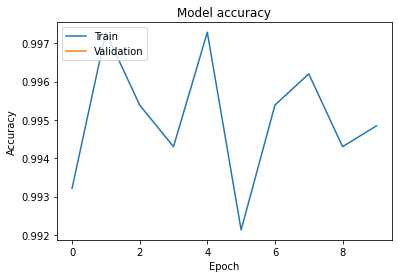

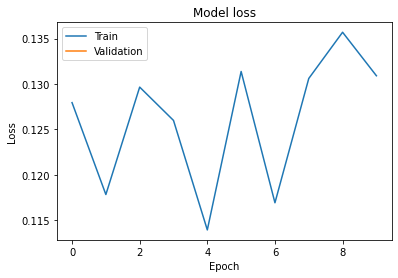

In [97]:
# Train the model
history = model.fit(
    dataset,  # The dataset you prepared earlier
    epochs=10
)

#Visualize Training
import matplotlib.pyplot as plt

# Plot training accuracy
plt.plot(history.history['class_output_accuracy'])
plt.plot(history.history.get('val_class_output_accuracy', []))  # If validation accuracy is available
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training loss
plt.plot(history.history['loss'])
plt.plot(history.history.get('val_loss', []))  # If validation loss is available
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [105]:
!pip install visualkeras

     |████████████████████████████████| 989 kB 8.3 MB/s eta 0:00:01


## Visualize Model

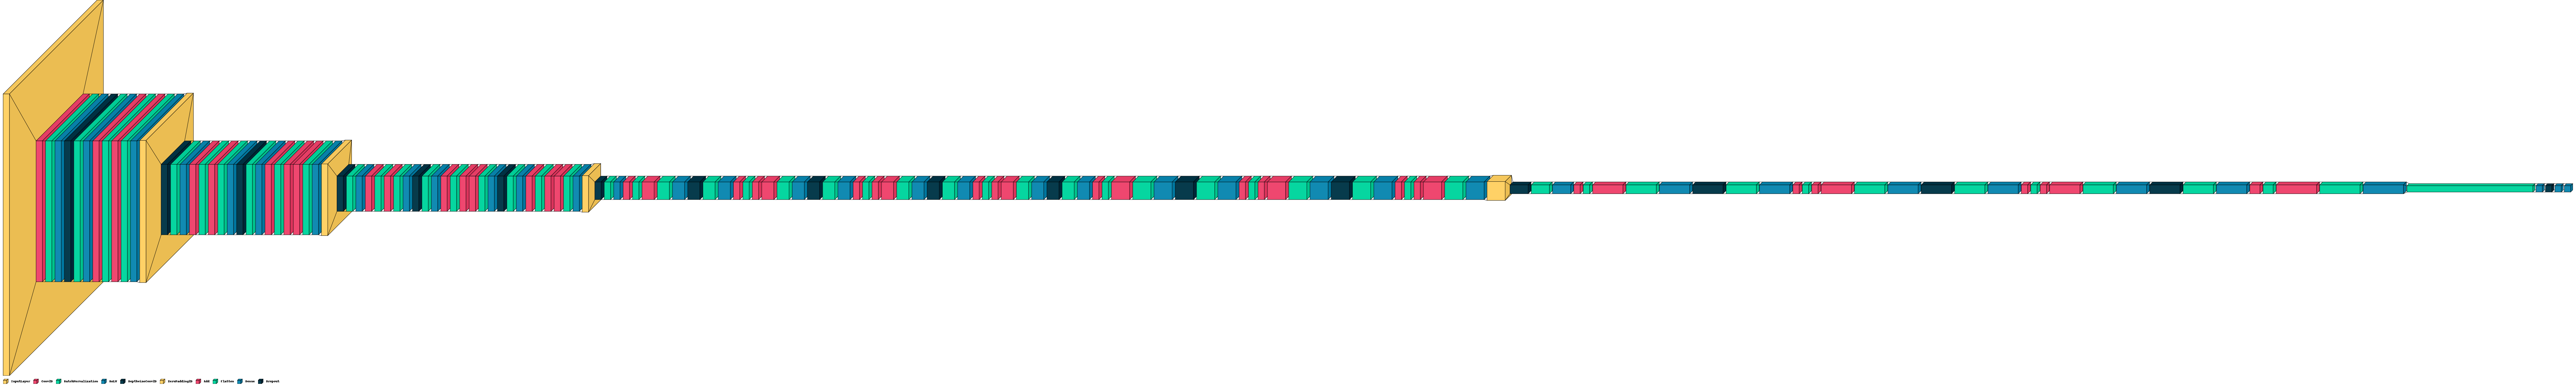

In [108]:
import visualkeras

visualkeras.layered_view(model, legend=True, to_file='model.png')

In [98]:
model.save('./RCNN_Model/RCNN_model.h5')

# Test Model

In [100]:
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)  
    img /= 255.0  # Normalize to [0, 1]
    return img

In [101]:
def draw_bbox(image, bbox, class_id, class_confidence):
    text = 'Dog' if class_id == 1 else 'Cat'
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    ax = plt.gca()

    xmin, ymin, xmax, ymax = bbox
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    plt.text(xmin, ymin, f'{text} ({class_confidence:.2f})', color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
    print(text)
    plt.axis('off')
    plt.show()


In [102]:
def predict_image(image_path, model):
    # Load and preprocess the image
    img = load_and_preprocess_image(image_path)
    original_img = load_img(image_path)  # Load original image for visualization

    # Predict
    predictions = model.predict(img)
    class_preds, bbox_preds = predictions

    # Class prediction
    class_id = np.argmax(class_preds[0])
    class_confidence = np.max(class_preds[0])

    # Bbox prediction (assuming bbox is normalized [xmin, ymin, xmax, ymax])
    xmin, ymin, xmax, ymax = bbox_preds[0]
    width, height = original_img.size
    bbox = [xmin * width, ymin * height, xmax * width, ymax * height]  # Scale bbox to original image size

    # Draw bbox on the image
    draw_bbox(np.array(original_img), bbox, class_id, class_confidence)


Cat


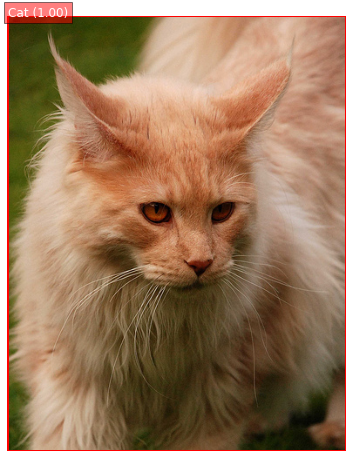

In [103]:
model_path = '/kaggle/working/RCNN_Model/RCNN_model.h5'
model = tf.keras.models.load_model(model_path)
image_path = '/kaggle/input/dog-and-cat-detection/images/Cats_Test1401.png'
predict_image(image_path, model)